# Decision Trees, Over- and Under-fitting, and the Bias-Variance Tradeoff
In this workbook, we will examine **decision trees**, a relatively straighforward technique for classification.   We will use the example dataset and model to introduce the ideas of over and underfitting a model, and the relationship of these ideas to bias and variance.

The data we will use is a public sample of pulsar data.   It includes feature data on approximately 18k human-labeled samples.   A full description of the data and the underlying analysis can be found in this thesis:
http://www.scienceguyrob.com/wp-content/uploads/2016/12/WhyArePulsarsHardToFind_Lyon_2016.pdf

The data come from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/HTRU2

# Some useful methods
We have our usual helpful methods to enable nested defaultdicts as well as getting access to plotting.

We introduce a new method: **getDecisionTreeGraphic**.   This method will allow us to visualize a Decision Tree classifier.


In [1]:
from collections import defaultdict
from functools import partial
from itertools import repeat
def nested_defaultdict(default_factory, depth=1):
    result = partial(defaultdict, default_factory)
    for _ in repeat(None, depth - 1):
        result = partial(defaultdict, result)
    return result()

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
%matplotlib inline

def getDecisionTreeGraphic(estimator,feature_names,class_names):
    from sklearn import tree
    from io import StringIO
    import pydot_ng as pydot 
    import graphviz
    import matplotlib.pyplot as plt

    dot_data = StringIO()

    #                         class_names=classColumn,
    out = tree.export_graphviz(estimator,out_file=None,
                           feature_names=feature_names,
                           class_names=class_names,
                           filled=True, rounded=True,
                           special_characters=True,
                            node_ids=1,)
    import pydotplus
    pydot_graph = pydotplus.graph_from_dot_data(out)
    pydot_graph.set_size('"7,7!"')
    #print(pydot_graph.getvalue())
    #graph = graphviz.Source( out)
    graph = graphviz.Source(pydot_graph.to_string())
    return graph


# Getting the data:
As usual the data is on github.   

In [2]:
import pandas as pd

#
# Read in all of the other digits
fname = '/fs/scratch/PAS1585/HTRU2/HTRU_2a.csv'
dfAll = pd.read_csv(fname)
dfAll.head(5)


,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [19]:
dfAll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
Profile_mean        17898 non-null float64
Profile_stdev       17898 non-null float64
Profile_skewness    17898 non-null float64
Profile_kurtosis    17898 non-null float64
DM_mean             17898 non-null float64
DM_stdev            17898 non-null float64
DM_skewness         17898 non-null float64
DM_kurtosis         17898 non-null float64
class               17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


# Defining Signal
The **class** variable distinguishes signal from background.   As usual,  **1** is signal (pulsars) and **0** is background.

In [3]:
#
# The data already has a 0/1 class variable that defines signal (1) and background (0)
#
# The data is already combined but it will be usefull to split it so we can look at 
# signal and background separately.
dfA = dfAll[dfAll['class']==1]
dfB = dfAll[dfAll['class']==0]

print("Length of signal sample:     ",len(dfA))
print("Length of background sample: ",len(dfB))

#
# Shuffle the data here
from sklearn.utils import shuffle
dfBShuffle = shuffle(dfB)
#
# Uncomment the next line to limit dfB to be the same length as dfA
#dfB_use = dfBShuffle
dfB_use = dfBShuffle.head(len(dfA))


dfCombined = dfB_use
dfCombined = pd.concat([dfCombined, dfA])
dfCombined = shuffle(dfCombined)

print("Size of signal sample ",len(dfA))
print("Size of background sample ",len(dfB_use))
print("Size of combined sample ",len(dfCombined))



Length of signal sample:      1639
Length of background sample:  16259
Size of signal sample  1639
Size of background sample  1639
Size of combined sample  3278


# Examine the Data

Let's do a quick visualization of the correlations - we can look at which variables ar emore strongly correlated with the **class** varaible.

In [4]:
corr = dfCombined.corr()
corr.style.background_gradient().set_precision(3)

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
Profile_mean,1,0.678,-0.942,-0.843,-0.594,-0.63,0.605,0.438,-0.775
Profile_stdev,0.678,1,-0.717,-0.73,-0.217,-0.326,0.322,0.256,-0.514
Profile_skewness,-0.942,-0.717,1,0.962,0.606,0.642,-0.611,-0.438,0.735
Profile_kurtosis,-0.843,-0.73,0.962,1,0.551,0.558,-0.532,-0.377,0.608
DM_mean,-0.594,-0.217,0.606,0.551,1,0.79,-0.699,-0.442,0.488
DM_stdev,-0.63,-0.326,0.642,0.558,0.79,1,-0.878,-0.661,0.662
DM_skewness,0.605,0.322,-0.611,-0.532,-0.699,-0.878,1,0.917,-0.63
DM_kurtosis,0.438,0.256,-0.438,-0.377,-0.442,-0.661,0.917,1,-0.492
class,-0.775,-0.514,0.735,0.608,0.488,0.662,-0.63,-0.492,1


# Some plots
The correlation table above indicates that **Profile_mean** and **Profile_skewness** are among the variables correlated strongly with **class**.   Let's plot signal and backgrund for those two variables.

In [20]:
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
import plotly.graph_objs as go

#
# First plot
variable = 'Profile_mean'
trace1 = go.Histogram(
    x=dfB_use[variable],
    opacity=0.75,
    name="Class=0",
    histnorm='probability'
)
trace2 = go.Histogram(
    x=dfA[variable],
    opacity=0.75,
    name="Class=1",
    histnorm='probability'
)

data = [trace1, trace2]
layout = dict(
    title='Comparing Pulsar Classes',
    xaxis=dict(title=variable),
    yaxis=dict(title='Fraction')
)
iplot(dict(data=data,layout=layout),validate=False)

#
# second plot
variable = 'Profile_skewness'
trace1 = go.Histogram(
    x=dfB_use[variable],
    opacity=0.75,
    name="Class=0",
    histnorm='probability'
)
trace2 = go.Histogram(
    x=dfA[variable],
    opacity=0.75,
    name="Class=1",
    histnorm='probability'
)

data = [trace1, trace2]
layout = dict(
    title='Comparing Pulsar Classes',
    xaxis=dict(title=variable),
    yaxis=dict(title='Fraction')
)
iplot(dict(data=data,layout=layout),validate=False)


# third plot
variable = 'DM_mean'
trace1 = go.Histogram(
    x=dfB_use[variable],
    opacity=0.75,
    name="Class=0",
    histnorm='probability'
)
trace2 = go.Histogram(
    x=dfA[variable],
    opacity=0.75,
    name="Class=1",
    histnorm='probability'
)

data = [trace1, trace2]
layout = dict(
    title='Comparing Pulsar Classes',
    xaxis=dict(title=variable),
    yaxis=dict(title='Fraction')
)
iplot(dict(data=data,layout=layout),validate=False)

## Additional: 
Look at a few of the other variables.

# Performance Method
Define this for later use.

In [6]:
#
# Determine the performance
def binaryPerformance(y,y_pred,y_score,debug=False):
#
# Assuming a binary classifier with 1=signal, 0=background
  confusionMatrix = nested_defaultdict(int,2)
  for i in range(len(y_pred)):
    trueClass = y[i]
    predClass = y_pred[i]
    confusionMatrix[trueClass][predClass] += 1

  if debug:
    for trueClass in range(2):
      print("True: ",trueClass,end="")
      for predClass in range(2):
        print("\t",confusionMatrix[trueClass][predClass],end="")
      print()
    print()
  TP = confusionMatrix[1][1]
  FP = confusionMatrix[0][1]
  FN = confusionMatrix[1][0]
  TN = confusionMatrix[0][0]
  
  if debug:
    print("TP predicted true, actually true   ",TP)
    print("FP predicted true, acutally false  ",FP)
    print("TN predicted false, actually false ",TN)
    print("FN predicted false, actually true  ",FN)


  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1_score = 2.0 / ( (1.0/precision) + (1.0/recall) )
  
  if debug:
    print("Precision = TP/(TP+FP) = fraction of predicted true actually true ",precision)
    print("Recall = TP/(TP+FN) = fraction of true class predicted to be true ",recall)
    print("F1 score = ",f1_score)

  #
  # Get the ROC curve.  We will use the sklearn function to do this
  from sklearn import metrics
  #fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_score, pos_label=1)
  fpr, tpr, thresholds = metrics.roc_curve(y, y_score, pos_label=1)
  #
  # Get the auc
  auc = metrics.roc_auc_score(y, y_score)
  if debug:
    print("AUC this sample: ",auc)
  
  return precision,recall,auc,fpr, tpr, thresholds

#  The runFitter Method
We will use the same form of the runFitter method we used for our k-fold validation study, with one exception.   In that case, our classifier was a pseudo-SVM (the LinearSVC).   To get a ROC curve (which is important for understanding perfromance) we need to **score** our results.   For LinearSVC, the score comes from its **decision_function** method.   For decision trees in sklearn, we will use the classifier **DecisionClassifier**, and this provides a **predict_prob** function (returning probabilites) instead of the decision_function method.   

In [7]:

def runFitter(estimator,X_train,y_train,X_test,y_test,debug=False):
#
# Now fit to our training set
  estimator.fit(X_train,y_train)
#
# Now predict the classes and get the score for our traing set
  y_train_pred = estimator.predict(X_train)
  y_train_score = estimator.predict_proba(X_train)[:,1]   # NOTE: some estimators have a predict_prob method instead od descision_function
#
# Now predict the classes and get the score for our test set
  y_test_pred = estimator.predict(X_test)
  y_test_score = estimator.predict_proba(X_test)[:,1]

#
# Now get the performaance
  precision_test,recall_test,auc_test,fpr_test, tpr_test, thresholds_test\
    = binaryPerformance(y_test,y_test_pred,y_test_score,debug)
  precision_train,recall_train,auc_train,fpr_train, tpr_train, thresholds_train\
    = binaryPerformance(y_train,y_train_pred,y_train_score,debug)
#
# Decide what you want to return: for now, just precision, recall, and auc for both test and train
  results = {
      'precision_train':precision_train,
      'recall_train':recall_train,
      'auc_train':auc_train,
      'fpr_train':fpr_train, 
      'tpr_train':tpr_train, 
      'thresholds_train':thresholds_train,
      'precision_test':precision_test,
      'recall_test':recall_test,
      'auc_test':auc_test,
      'fpr_test':fpr_test, 
      'tpr_test':tpr_test, 
      'thresholds_test':thresholds_test}

  return results
  

# Prepare the data
As usual we shuffle it first and then dump the dataframe into an **X** features numpy array and a **y** labels numpy array.

In [8]:
from sklearn.utils import shuffle
dfCombinedShuffle = shuffle(dfCombined,random_state=42)    # by setting the random state we will get reproducible results

X = dfCombinedShuffle.as_matrix(columns=dfCombinedShuffle.columns[:8])
y = dfCombinedShuffle['class'].values

/apps/project/ondemand/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



# Run the fitter
Now we can use the function we defined above.   We are going to use the "DecisionTreeClassifier", and initially we will not use k-fold validation.   Let's just see how the decision tree works.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#
# Note that we can give trainm_test_split *two* arrays as input!   The order of the output
# is crucial though!!!
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
#
# Define our estimator.     
estimator = DecisionTreeClassifier(random_state=42)
#
# Get the results and printout
results = runFitter(estimator,X_train,y_train,X_test,y_test,debug=False)
print("Precision train/test ",round(results['precision_train'],3),round(results['precision_test'],3))
print("Recall train/test    ",round(results['recall_train'],3),round(results['recall_test'],3))
print("AUC train/test       ",round(results['auc_train'],3),round(results['auc_test'],3))
 
#

Precision train/test  1.0 0.919
Recall train/test     1.0 0.911
AUC train/test        1.0 0.913


## Examine Results
Why are the training values all 1.0 and the testing values all around 0.9?   Perfect performance on the training sample is not actually a good thing!

It turns out that the decision tree - if not limited, will continue to add nodes until it perfectly separates the training sample into signal and background.   It has **overfit** the training data, and effectively **memorized** the signal and background.  But this comes at the cost of **generalization**.    The trained model finds it difficult to generalize its procedure to new unseen testing data.   To fix this, we need to limit the decision tree so that it can't overfit.   

If we look at sklearn in detail at how the DecisionTreeClassifier can be called, we will see the parameters that we can play with:

    class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)

Here are the descriptions of some of the key parameters:
*  **max_depth : int or None, optional (default=None)**
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

*  **min_samples_split : int, float, optional (default=2)**
The minimum number of samples required to split an internal node:
If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

*  **min_samples_leaf : int, float, optional (default=1)**
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
If int, then consider min_samples_leaf as the minimum number.
If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

* **max_leaf_nodes : int or None, optional (default=None)**
Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

To help us understand the decision tree we ended up with, it turns out we have access to a nice visualization tool (included in the methods at the top of this workbook).   Lets call it and see what the (overtrained) tree looks like when it is trained using all of the default parameters:

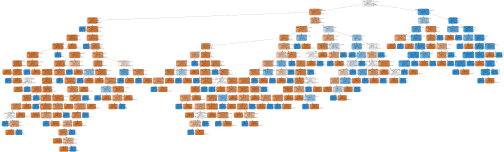

In [10]:
from IPython.display import SVG
class_names = {0:"background",1:"signal"}
classColumn='class'
feature_names = [col for col in dfCombined.columns if col!=classColumn]
graph = getDecisionTreeGraphic(estimator,feature_names,class_names)
SVG(graph.pipe(format='svg'))

## Making a simpler Decision Tree
The default tree ended up with more than 200 **interior nodes** and **leaves**, which makes it quite difficult to understand.   (Aside: why is it so complicated?   By default, an unconstrained tree will **grow** until every final **leaf** is pure.   More on that later.)   Let's try limiting that by requiring the number of leaves (which are nodes with no children) to something more manageable: we will set max_leaf_nodes=3.   We will define the estimator with this parameter, run the algorithm, and then display the resultant decision tree.

Precision train/test  0.966 0.958
Recall train/test     0.892 0.884
AUC train/test        0.956 0.943


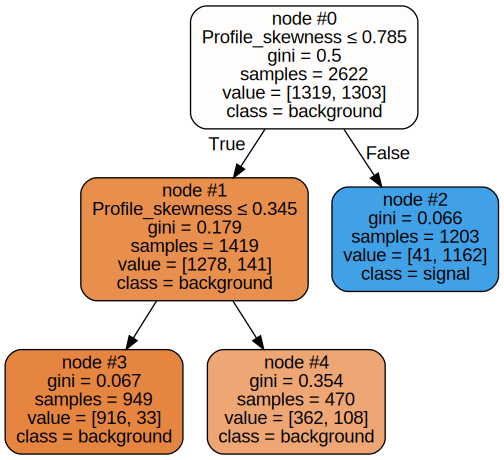

In [11]:
#
# Modify the parameters of the tree we will train
estimator = DecisionTreeClassifier(random_state=42,max_leaf_nodes=3)
#
# Fit the tree
results = runFitter(estimator,X_train,y_train,X_test,y_test,debug=False)
#
# Print results
print("Precision train/test ",round(results['precision_train'],3),round(results['precision_test'],3))
print("Recall train/test    ",round(results['recall_train'],3),round(results['recall_test'],3))
print("AUC train/test       ",round(results['auc_train'],3),round(results['auc_test'],3))
#
# Plot the tree!
graph = getDecisionTreeGraphic(estimator,feature_names,class_names)
SVG(graph.pipe(format='svg'))

## Another simple (but different!) Decision Tree
That one above looks much simpler!    Before going into detail on what the various parts mean, let's try another parameter: the number of levels in the tree.    We adjust this using **max_depth**.

Precision train/test  0.956 0.936
Recall train/test     0.935 0.92
AUC train/test        0.974 0.96


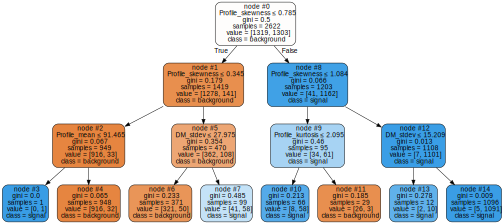

In [12]:
#
# Restrict levels (depth) to 3
estimator = DecisionTreeClassifier(random_state=42,max_depth=3)
#
# Fit the tree
results = runFitter(estimator,X_train,y_train,X_test,y_test,debug=False)
#
# Print out
print("Precision train/test ",round(results['precision_train'],3),round(results['precision_test'],3))
print("Recall train/test    ",round(results['recall_train'],3),round(results['recall_test'],3))
print("AUC train/test       ",round(results['auc_train'],3),round(results['auc_test'],3))
#
# PLot the tree
graph = getDecisionTreeGraphic(estimator,feature_names,class_names)
SVG(graph.pipe(format='svg'))

## Examination of the tree
Let's look at this last tree in detail.   
**NOTE**: since there may be slight variances in the random number generators used in my workbook and yours, the numbers above in the tree may be slightly different.   Here is a screenshot of the tree corresponding to the numbers below:
![my tree](https://github.com/big-data-analytics-physics/data/blob/master/images/simleTree2.png?raw=true)

There are a few things to point out:
1.  The is one root node - node #0 at the very top of the tree.   Looking at the text in this node:
    * node #0: This is the node name.
    * Cut: Profile_skewness ≤ 0.889.    This the cut that the children of this node either pass and go to the left (labeled "True") or fail and go to the right (labeled "False").   
     * gini = 0.5:   This is the **gini impurity** of the root node.   We will cover this below, but note that for a balanced dataset with equal or nearly equal signal and background, gini=0.5 for the root node. (**NOTE**: gini **coefficient** is a different idea.  It is also sometimes called the gini index, or the gini ratio, and is a measure of statistical dispersion.  Also note that, unfortunately, some writeups of Decision Trees confuse these terms.)
     * samples = 2622: This is the number of samples in *this* node.
     * value = [1288, 1334]:  This is the **actual** number of background (1288) and signal (1334) the node has.   Note the this is **different** than the number that go to the left (1431) and the right (1191), which you find by looking at the **samples** number of the children of this node.
     * class = background: This is the class characterization of the node.   Since there are slighty more background than signal, this node is counted as background.   Note that the nodes get more orange the more background the node has, and more blue the more signal the node has.
2.   There are 8 **leaves** in this tree.   A leaf is a node with no children.   It turns out that for this tree, all of the leaves are on the bottom level, but  this is not usually the case (look at the previous 2 trees to see this).
3.  Looking at the left-most leaf on the bottom level we see two imortant things:
     * value = [593, 9]  This means that if a new sample landed on this node, it would have a probability of $p_0$=593/602 of being background, and a probability of $p_1$=9/602 of being signal.
     * gini=0.029:   A much lower **gini impurity**.   What is gini impurity?
\begin{equation*}
G = 1.0 - \sum_{i=1}^J p_i^2
\end{equation*}
where in our case J=2 (because we have two classes).   Substituting $p_0$=593/602 and $p_1$=9/602 yields G=0.029.
The **gini impurity**  of a node is the probability that a randomly chosen sample in a node would be incorrectly labeled, if it was labeled by the distribution of samples in the node. 

This gives us some insight into how a decision tree is formed:   At each node, the algorithm loops over all of the features *k* and all possible splits (or thresholds) $t_k$ among those features, to determine a split (or cut point) that results in the purest children of that node.   Mathematically, it finds the pair $(k,t_k)$ that minimizes the following cost function:
\begin{equation}
J(k,t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right}
\end{equation}
where *left* and *right* refer the the child on the left or right.

     

# Now include k-fold cross validation
Let's retrain the same tree (the second *simple* version), but now include cross validation.

In [13]:
from sklearn.model_selection import StratifiedKFold
kfolds = 5
skf = StratifiedKFold(n_splits=kfolds)

In [14]:
#
# Get our estimator and predict
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(random_state=42,max_depth=3)
avg_precision_train = 0.0
avg_recall_train = 0.0
avg_auc_train = 0.0
avg_precision_test = 0.0
avg_recall_test = 0.0
avg_auc_test = 0.0
numSplits = 0.0
#
# Now loop
for train_index, test_index in skf.split(X, y):
  print("Training")
  numSplits += 1
  X_train = X[train_index]
  y_train = y[train_index]
  X_test = X[test_index]
  y_test = y[test_index]
  
#
# Now fit to our training set
  results = runFitter(estimator,X_train,y_train,X_test,y_test,debug=False)

  avg_precision_train += results['precision_train']
  avg_recall_train += results['recall_train']
  avg_auc_train += results['auc_train']
#
  avg_precision_test += results['precision_test']
  avg_recall_test += results['recall_test']
  avg_auc_test += results['auc_test']
#
avg_precision_train /= numSplits
avg_recall_train /= numSplits
avg_auc_train /= numSplits
avg_precision_test /= numSplits
avg_recall_test /= numSplits
avg_auc_test /= numSplits
# 
# Now print
print("Precision train/test ",round(avg_precision_train,3),round(avg_precision_test,3))
print("Recall train/test    ",round(avg_recall_train,3),round(avg_recall_test,3))
print("AUC train/test       ",round(avg_auc_train,3),round(avg_auc_test,3))

Training
Training
Training
Training
Training
Precision train/test  0.951 0.945
Recall train/test     0.929 0.926
AUC train/test        0.974 0.968


# Overfitting vs Underfitting
We have seen a very compex tree (allowing the tree to **fully grow** until all leaves are pure) as well as a couple of very simple trees.  Of course, we have many possible choices for the various hyperparameters, which will lead to a variety of different expected performance measures.   How do we choose among all of the possibilities?

Let's modify the above k-fold validation, putting it inside of a loop that varies the hyperparameters.   We will store the resultant performance measures, and then plot them versus our hyperparameters.   

For our test, we will vary just one hyperparemter (the tree max_depth) but we could easily do this over multiple hyperparameters.

**NOTE**: we will make one change.   Rather than storing precision, recall, and AUC, which in some sense reflect **accuracy** of our models, we will instead store 1-precision, 1-recall, and 1-AUC, which will reflect **error** in our models.

In [15]:
#
# Get our estimator and predict
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
#
# Create a dataframe to store our results
dfError = pd.DataFrame(columns=['max_depth','trainError_pre','testError_pre',
                                    'trainError_rec','testError_rec',
                                    'trainError_auc','testError_auc'])
#
# OUTER loop over hyperparameters
for max_depth in range(1,20):
  print("training with max depth =",max_depth)
  estimator = DecisionTreeClassifier(random_state=42,max_depth=max_depth)
  avg_precision_train = 0.0
  avg_recall_train = 0.0
  avg_auc_train = 0.0
  avg_precision_test = 0.0
  avg_recall_test = 0.0
  avg_auc_test = 0.0
  numSplits = 0.0
#
# INNER loop over k-fold splits
  for train_index, test_index in skf.split(X, y):
    numSplits += 1
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

#
# Now fit to our training set
    results = runFitter(estimator,X_train,y_train,X_test,y_test,debug=False)
    #print("results",results)

    avg_precision_train += results['precision_train']
    avg_recall_train += results['recall_train']
    avg_auc_train += results['auc_train']
#
    avg_precision_test += results['precision_test']
    avg_recall_test += results['recall_test']
    avg_auc_test += results['auc_test']
#
# Store the results for each HYPERPARAMETER iteration
  avg_precision_train /= numSplits
  avg_recall_train /= numSplits
  avg_auc_train /= numSplits
  avg_precision_test /= numSplits
  avg_recall_test /= numSplits
  avg_auc_test /= numSplits
#
# Fill dataframe
  dfError = dfError.append({
     'max_depth':max_depth,
     'trainError_pre':1.0-avg_precision_train,'testError_pre':1.0-avg_precision_test,
     'trainError_rec':1.0-avg_recall_train,'testError_rec':1.0-avg_recall_test,
     'trainError_auc':1.0-avg_auc_train,'testError_auc':1.0-avg_auc_test
      }, ignore_index=True)
# 
# Now print
print(dfError.head(10))

training with max depth = 1
training with max depth = 2
training with max depth = 3
training with max depth = 4
training with max depth = 5
training with max depth = 6
training with max depth = 7
training with max depth = 8
training with max depth = 9
training with max depth = 10
training with max depth = 11
training with max depth = 12
training with max depth = 13
training with max depth = 14
training with max depth = 15
training with max depth = 16
training with max depth = 17
training with max depth = 18
training with max depth = 19
   max_depth  trainError_pre  testError_pre  trainError_rec  testError_rec  \
0        1.0        0.034424       0.035045        0.110280       0.111639   
1        2.0        0.025087       0.030659        0.118365       0.121396   
2        3.0        0.048549       0.054719        0.070927       0.074424   
3        4.0        0.032231       0.044709        0.070621       0.079913   
4        5.0        0.019595       0.043270        0.071080       0.

# Plotting results

Lets look at the error measures:
1.  train/test Error using precision: remember that **precision** = TP/(TP+FP) = "Total actual positive found as positive" / "Total our model identified as positive".   It is the fraction of identified postives that are truly positive.   **(1-precision)** is then the **error** - the fraction of our identified postives that are incorrect.
2.  train/test Error using recall: remember that **recall** = TP/(TP+FN) = "Total actual positive found as positive" / "Total actual positive".   It is the fraction of actual positives that our model managed to identify.   **(1-recall)** is then the **error** - the fraction of actual postives that we failed to identify.
3.  train/test Error using AUC: remember that AUC measures the probability that a randomly chosen positive example is properly ranked above a randomly chosen negative example.   **(1-AUC)** is then the probability that we will fail to do this.

In [16]:
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
import plotly.graph_objs as go

# Create a trace
trace1 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['trainError_pre'],
    mode = 'lines',
    name = "Training error"
)
# Create a trace
trace2 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['testError_pre'],
    mode = 'lines',
    name = "Testing Error"
)

layout = dict(
    title='Error (Precision) vs Model Complexity',
    xaxis=dict(title='max_depth'),
    yaxis=dict(title='Error (fraction)')
)

data = [trace1, trace2]
iplot(dict(data=data,layout=layout),validate=False)

# Create a trace
trace1 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['trainError_rec'],
    mode = 'lines',
    name = "Training error"
)
# Create a trace
trace2 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['testError_rec'],
    mode = 'lines',
    name = "Testing Error"
)

layout = dict(
    title='Error (Recall) vs Model Complexity',
    xaxis=dict(title='max_depth'),
    yaxis=dict(title='Error (fraction)')
)

data = [trace1, trace2]
iplot(dict(data=data,layout=layout),validate=False)
# Create a trace
trace1 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['trainError_auc'],
    mode = 'lines',
    name = "Training error"
)
# Create a trace
trace2 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['testError_auc'],
    mode = 'lines',
    name = "Testing Error"
)

layout = dict(
    title='Error (AUC) vs Model Complexity',
    xaxis=dict(title='max_depth'),
    yaxis=dict(title='Error (fraction)')
)

data = [trace1, trace2]
iplot(dict(data=data,layout=layout),validate=False)


# Defining Underfitting and Overfitting Regions
Looking at the AUC error vs max_depth curve we can see some general trends:
1.   Note that as max_depth increases from left to right, we allow the model to get progressively more complex.
2.   At the far left, as we go from very low complexity to slightly higher complexity, both the training error and the testing error go down.   This is typical.   Also note that the testing error is usually a bit above the trainining error in this region - also fairly typical.   In this region, the model is **underfit** - it still has room to improve on the testing set.
      * Underfit models tend to have the similar fit performance on a testing set as they do on a training set.
3.   As the complexity increases, around max_depth of 4 or so, the training error decreases, and so does the testing error, but the testing error begins to level out.   What is happening here is that our trained model is becoming more sensitive to features found only in the training set, and so the perfromance on the testing set improves less.
4.  Beyond max_depth of 5-6, the model performance continue to improve on the training set, and begins to get **worse** on the testing set.   The model is now **overfit** - it is memorizing the training set, at the expense of learning general features which would allow it to improve on the testing set.
      * Overfit models tend to have  worser fit performance on a testing set than they do on a training set.



In [17]:

import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
import plotly.graph_objs as go

# Create a trace
trace1 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['trainError_auc'],
    mode = 'lines',
    name = "Training error"
)
# Create a trace
trace2 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['testError_auc'],
    mode = 'lines',
    name = "Testing Error"
)

layout = dict(
    title='Error (AUC) vs Model Complexity',
    xaxis=dict(title='max_depth (model complexity)'),
    yaxis=dict(title='Error (fraction)'),
    shapes=[
      {
        "opacity": 0.2,
        "xref": "x",
        "yref": "y",
        "fillcolor": "#d3d3d3",
        "y1": 0.09,
        "y0": 0.0,
        "x0": 1,
        "x1": 3,
        "type": "rect"
      },
      {
        "opacity": 0.2,
        "xref": "x",
        "yref": "y",
        "fillcolor": "#d3d3d3",
        "y1": 0.09,
        "y0": 0.0,
        "x0": 5,
        "x1": 20,
        "type": "rect"
      }
    ],
    annotations= [
      {
        "xref": "x",
        "yref": "y",
        "text": "Underfit Model",
        "y": 0.095,
        "x": 2.0,
        "font": {
          "color": "rgb(255, 0, 0)",
          "size": 18
        },
        "showarrow": False
      },
      {
        "xref": "x",
        "yref": "y",
        "text": "Progressively more Overfit Model",
        "y": 0.095,
        "x": 12.5,
        "font": {
          "color": "rgb(255, 0, 0)",
          "size": 18
        },
        "showarrow": False
      }
    ]
)

data = [trace1, trace2]
iplot(dict(data=data,layout=layout),validate=False)



# The Bias-Variance Tradeoff
The issue of over and under fitting in our models is strongly related to the concepts of bias and variance.   Within the context of classification:
1.  **Bias** refers to the systematic difference between the average of our predictions and the average of the true labels in our dataset.
     *  Bias decreases with increasing complexity of our model
     *  Bias generally does not depend on training set size.
     *  We want **low bias**.  If the bias is large, **both** training and testing error will be large, and the model is **underfit**.
2. **Variance** refers to the difference between the predictions and our labels for different realizations of the same model.
     * Variance increases with increasing complexity of our model.
     * Variance decreases with training set size.
     * We want **low variance**.   If the variance is large, the testing error will be significantly larger than the training error, and the model is **overfit**.
     
An excellent discussion of these points can be found in this [reference](http://scott.fortmann-roe.com/docs/BiasVariance.html).   The key idea is that although we want both **low bias** and **low variance**, we have only one knob to turn: the complexity of our model.   As we increase the complexity, we can get bias to go down, but eventually, variance will go up.   

In practice this is handled by making the above error plot: we compare the error on the **testing** set to the error on the **training** set.   We expect these both to decrease up to some point, beyond which the testing error increases, while the training error continues to decrease.   We choose our model operating point (the hyperparameters) which correspond to the minimum of our testing error.
